Supporting script for:

**How to make climate-neutral aviation fly** \
*Romain Sacchi, Viola Becattini, Paolo Gabrielli, Brian Cox, Alois Dirnaichner, Christian Bauer, and Marco Mazzotti*

Questions: romain.sacchi(at)psi.ch

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.linalg import toeplitz
import matplotlib.ticker as plticker
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings("ignore")
import itertools
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.offsetbox import AnchoredText

def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

In [114]:
df_sens = pd.DataFrame()

for _sens in range(1, 9):
    print(f"Scenario {_sens}")

    # load time series of CO2 and SLCF emissions
    df = pd.read_excel(f"sensitivity/{_sens}/results sensitivity {_sens}.xlsx", skiprows=0) # <-- in kg/year

    # we rename the columns for simplicity
    df.columns = ['Tg/year', 'fuel', 'background', 'scenario', "km", 'HFC-152a', 'H',
                   'HCFC-140', 'HCFC-22', 'CH4', 'HFC-134a', 'R-10',
                   'HFC-125', 'CFC-11', 'HFC-143a', 'CFC-113',
                   'CO2', 'CO2 (flight)', 'NOx',
                   'BC', 'SOx', 'H2O', 'Cirrus',
                   "LOP - infras.", "LOP - fuel supply", "LOP - compensation",
                   "FWD - infras.", "FWD - fuel supply", "FWD - compensation",
                   "electricity - infras.", "electricity - fuel supply", "electricity - LOP", "electricity - FWD", "electricity - compensation",
                   "cost - infras-", "cost - fuel supply", "cost - kerosene", "cost - FT", "cost - H2", "cost - DAC", "cost - compensation"   
    ]
    df = df.fillna(0)

    start = 2018
    end = 2100
    alpha=.8

    # returns linear operator to convert emissions to forcing
    # from Lynch et al. 2021
    def EFmod(nyr,a):
        Fcal = np.zeros((nyr)) # create linear operator to convert emissions to forcing
        time = np.arange(nyr+1)    # extend time array to compute derivatives
        F_0 = a[4]*a[13]*a[0]*time # compute constant term (if there is one, otherwise a[0]=0)
        for j in [1,2,3]:          # loop over gas decay terms to calculate AGWP using AR5 formula
            F_0=F_0+a[j]*a[4]*a[13]*a[j+5]*(1-np.exp(-time/a[j+5]))
        for i in range(0,nyr):     # first-difference AGWP to obtain AGFP
            Fcal[i]=F_0[i+1]-F_0[i]

        return toeplitz(Fcal, np.zeros_like(Fcal))

    # Radiative forcing for SLCPs
    # mW/m^2/Mt

    RFI = {
        "medium": {
            "HFC-152a": 8.71e-12 * 1e9 * 1e3,
            "H": 3.64e-13 * 1e9 * 1e3,
            "HCFC-140": 2.75e-12 * 1e9 * 1e3,
            "HCFC-22": 1.4e-11 * 1e9 * 1e3,
            "CH4": 1.36e-13 * 1e9 * 1e3,
            "HFC-134a": 9.23e-12 * 1e9 * 1e3,
            "R-10": 6.09e-12 * 1e9 * 1e3,
            "HFC-125": 1.1e-11 * 1e9 * 1e3,
            "CFC-11": 1.06e-11 * 1e9 * 1e3,
            "HFC-143a": 1.13e-11 * 1e9 * 1e3,
            "CFC-113": 9.06e-12 * 1e9 * 1e3,
            "CO2": 1.70E-15 * 1e9 * 1e3,
            "NOx": 5.5 *(14/46), # RF coeff. for NOx
            "BC": 100.67, # RF coeff. for BC
            "SOx": -19.91, # RF coeff. for SO4
            "H2O": 0.0052, # RF coeff. for H2O
            "Cirrus": 9.36e-10 if _sens != 5 else 9.36e-10 * 0.14 # RF coeff. for Cirrus
        }
    }


    # molecular mass for SLCPs
    # kg/mol
    mol_mass = {
        "HFC-152a":66.05 / 1e3,
        "H": 1.01 / 1e3,
        "HCFC-140": 133.4 / 1e3,
        "HCFC-22": 86.47 / 1e3,
        "CH4": 16.04 / 1e3,
        "HFC-134a": 102.03 / 1e3,
        "R-10": 153.823 / 1e3,
        "HFC-125": 120.02 / 1e3,
        "CFC-11": 137.37 / 1e3,
        "HFC-143a": 84.04 / 1e3,
        "CFC-113": 187.375 / 1e3,
        'NOx': 14/1e3,
        'BC': 12/1e3, 
        'SOx': 64/1e3, 
        'H2O': 18/1e3,
        "Cirrus": 0
    }

    # lifetimes for SLCPs
    # years
    RF_lifetime = {
        "HFC-152a":1.6,
        "H": 2.5,
        "HCFC-140": 5,
        "HCFC-22": 11.9,
        "CH4": 11.8,
        "HFC-134a": 14,
        "R-10": 32,
        "HFC-125": 30,
        "CFC-11": 52,
        "HFC-143a": 51,
        "CFC-113": 93,
        'NOx': 11.8,
        'BC': 0.02, 
        'SOx': 0.011, 
        'H2O': 0.8,
        "Cirrus": 0.00057
    }

    # first set up AR5 model parameters, using syntax of FaIRv1.3 but units of GtCO2, not GtC
    ny2=len(range(start, end + 1))

    m_atm=5.1352*10**18 # AR5 official mass of atmosphere in kg
    m_air=28.97*10**-3  # AR5 official molar mass of air
    m_co2=44.01*10**-3  # AR5 official molar mass of CO2

    a_ar5=np.zeros(20)

    # Set to AR5 Values for CO2
    a_ar5[0:4] = [0.21787,0.22896,0.28454,0.26863]
    a_ar5[4] = 1.e12*1.e6/m_co2/(m_atm/m_air)# old value = 0.471 ppm/GtC # convert GtCO2 to ppm
    a_ar5[5:9] = [1.e8,381.330,34.7850,4.12370]
    a_ar5[10:12] = [0.631*0.7,0.429*0.7] #AR5 sensitivity coeffs multiplied by 0.7 to give ECS of 2.75K
    a_ar5[13] = 1.37e-2 # rad efficiency in W/m2/ppm
    a_ar5[14] = 0
    a_ar5[15:17] = [8.400,409.5]
    a_ar5[18:21] = 0

    FCO2 = EFmod(ny2,a_ar5)
    FCO2_inv = np.linalg.inv(FCO2)


    # load unitary emissions from DAC
    dac = pd.read_excel(f"sensitivity/{_sens}/DAC results {_sens}.xlsx", skiprows=0)

    # rename columns
    dac.columns = [
       'background', 'year', 'HFC-152a', 'H', 'HCFC-140', 'HCFC-22', 'CH4', 'HFC-134a', 'R-10','HFC-125', 'CFC-11', 'HFC-143a', 'CFC-113', 'CO2',
       "flight - CO2", "flight - NOx", "flight - Black carbon", "flight - Sulfur oxides", "flight - Water vapour", "flight - Cirrus",
       "LOP - infras.", "LOP - fuel supply", "LOP - compensation",
       "FWD - infras.", "FWD - fuel supply", "FWD - compensation",
       "electricity - infras.", "electricity - fuel supply", "electricity - LOP", "electricity - FWD", "electricity - compensation",
       "cost - infras.", "cost - fuel supply", "cost - kerosene", "cost - FT", "cost - H2", "cost - DAC", "cost - compensation"          
    ]

    dac = dac.fillna(0)

    d_colors = {
        'HFC-152a':"green",
        'H':"orange",
        'HCFC-140':"red",
        'HCFC-22':"brown",
        'CH4':"grey",
        'HFC-134a':"magenta",
        'R-10':"cyan",
        'HFC-125':"olive",
        'CFC-11':"purple",
        'HFC-143a':"pink",
        'CFC-113':"black",
        'CO2': "royalblue"
    }

    d_map = {
        "surface - CO2": "CO2",
        "surface - Others": ['HFC-152a', 'H', 'HCFC-140', 'HCFC-22', 'CH4', 'HFC-134a', 'R-10', 'HFC-125', 'CFC-11', 'HFC-143a', 'CFC-113',],
        "flight - CO2": "CO2 (flight)",
        "flight - Cirrus": "Cirrus",
        "flight - NOx": "NOx",
        "flight - Others": ['BC', 'SOx', 'H2O']
    }
    d_map_rev = {
        "CO2": "surface - CO2",
        'HFC-152a': "surface - Others", 
        'H': "surface - Others", 
        'HCFC-140': "surface - Others", 
        'HCFC-22': "surface - Others", 
        'CH4': "surface - Others", 
        'HFC-134a': "surface - Others", 
        'R-10': "surface - Others", 
        'HFC-125': "surface - Others", 
        'CFC-11': "surface - Others", 
        'HFC-143a': "surface - Others", 
        'CFC-113': "surface - Others",
        "CO2 (flight)": "flight - CO2",
        "Cirrus": "flight - Cirrus",
        "NOx": "flight - NOx",
        'BC': "flight - Others", 
        'SOx': "flight - Others", 
        'H2O': "flight - Others"
    }

    alfa = 0.6

    col_tuples = []
    col_tuples2 = []
    for a in ["flight CO2-neutral", "warming-neutral", "climate-neutral"]:
        for b in dac.columns[1:]:
            col_tuples.append((a, b))
        for c in d_map:
            col_tuples2.append((a, c))

    case = "medium"

    y = range(2018, 2101)
    a = ["Paris Agreement"]
    b = ["Growth"]
    c = ["jet fuel", "syn-jet fuel"]
    d = ["medium"]
    e = ["climate-neutral"]
    indices = np.array(list(itertools.product(a, b, c, d, e, y)))

    col_tuples3 = ["background", "scenario", "fuel", "case", "mitigation"] + list(dac.columns)[20:] + ["storage - infras.", "storage - fuel supply", "storage - compensation"]
    df_results = pd.DataFrame(0, index=np.arange(2018, 2101).tolist() * 2, columns=col_tuples3)
    df_results.loc[:, ["background", "scenario", "fuel", "case", "mitigation"]] = indices[:, :-1]


    for background in [
        #"Business As Usual", 
        "Paris Agreement"
    ]:

        for fuel in [
            "jet fuel", 
            "syn-jet fuel"
        ]:
            if _sens in [7, 8] and fuel == "jet fuel":
                continue

            # slice data of interest
            data = df.loc[(df["fuel"] == fuel)&(df["background"] == background), :'Cirrus']
            data = data.loc[data["Tg/year"].isin(range(start, end + 1))]

            scenarios = [
                "Growth",
                #"Stationary",
                #"Decline",
            ]

            metrics = [
                "Amount",
                "RF",
                "CDR",
            ]

            for s, scenario in enumerate(scenarios):
                for m, metric in enumerate(metrics):

                    ############################## EMISSIONS ###################################################
                    # plot annual emissions in Mtons
                    if metric == "Amount":

                        E = pd.DataFrame(
                            columns=[
                                "surface - CO2",
                                "surface - Others",
                                "flight - CO2",
                                "flight - Cirrus",
                                "flight - NOx",
                                "flight - Others"
                            ],
                            index = range(start, end + 1)
                        )

                        for k, v in d_map.items():
                            if isinstance(v, list):
                                E.loc[:, k] = (data.loc[(data["scenario"]==scenario), v].sum(1) / 1e9).values
                            else:
                                E.loc[:, k] = (data.loc[(data["scenario"]==scenario), v] / 1e9).values

                        l_E = [
                                "surface - CO2",
                                "surface - Others",
                                "flight - CO2",
                                "flight - NOx",
                                "flight - Others"
                            ]


                    else:
                        ############################# RADIATIVE FORCING ############################################
                        # plot annual forcing, in mW/m^2

                        RF = pd.DataFrame(
                            columns=[
                                "surface - CO2",
                                "surface - Others",
                                "flight - CO2",
                                "flight - Cirrus",
                                "flight - NOx",
                                "flight - Others"
                            ],
                            index = range(start, end + 1)
                        )
                        RF.loc[:, :] = 0
                        
                        for r in data.loc[:, 'HFC-152a': 'Cirrus'].columns:
                            if r not in ["CO2", "CO2 (flight)"]:
                                # Set to AR6 Values for substance
                                a_sub=a_ar5.copy()
                                a_sub[0:4]=[0,1.0,0,0]
                                a_sub[4]= 1 # Mt
                                a_sub[5:9]= [1, RF_lifetime[r], 1, 1]
                                a_sub[13]= RFI["medium"][r] / 1e3 # Radiative efficiency in W/m2/Mton

                                Fsub = EFmod(ny2, a_sub)

                                if r != "Cirrus":
                                    # LWE = FCO2^-1 * Fsub * Esub
                                    RF.loc[:, d_map_rev[r]] += Fsub@(data.loc[(data["scenario"]==scenario), r] / 1e9 * 1e3) # <-- W to mW
                                    
                                else:
                                    RF.loc[:, "flight - Cirrus"] = (data.loc[(data["scenario"]==scenario), r]).values * RFI["medium"][r]
                                    
                            else:
                                # LWE = FCO2^-1 * Fsub * Esub
                                RF.loc[:, d_map_rev[r]] = FCO2@(data.loc[(data["scenario"]==scenario), r] / 1e9).values # <-- W to mW
                                
                        no_mitig = RF.copy()

                        only_CO2 = RF.copy()
                        only_CO2.loc[2050:, "flight - CO2"] = RF.loc[2049, "flight - CO2"]

                        warming_neutral = RF.copy()
                        warming_neutral.loc[2050:] = warming_neutral.loc[2049, :].values[None, :]

                        climate_neutral = RF.copy()
                        climate_neutral.loc[2050:] = 0

                        only_CO2 = only_CO2.where(only_CO2 < no_mitig, no_mitig)

                        if only_CO2.sum(1).sum() < warming_neutral.sum(1).sum():
                            only_CO2 -= (only_CO2 - warming_neutral)


                        if metric == "RF":

                            ####### Temp increase relative to 2018 ##########
                            temp_res = []
                            for i, x in enumerate([no_mitig, only_CO2, warming_neutral, climate_neutral]):
                                # the whole 2018-2100 radiative forcing timeseries
                                d = RF.sum(1).copy()

                                # from 2050 to 2100, we replace the RF valeus 
                                # with the RF from the mitigation pathway
                                d.loc[2050:] = x.sum(1)

                                total_CO2 = (FCO2_inv@d) / 1e3
                                TCRE = 0.00045
                                temp = total_CO2.cumsum() * TCRE
                                temp = np.round(temp[-1], 3)

                                if i == 3:
                                    temp_list_res = []
                                    temp_list_res.append(RF.sum(1).values.tolist())
                                    temp_list_res.append(((FCO2_inv@RF.sum(1)) / 1e3).tolist())
                                    temp_list_res.append(d.values.tolist())
                                    temp_list_res.append(total_CO2.tolist())
                                    temp_list_res.append(total_CO2.cumsum().tolist())

                                if temp not in temp_res:
                                    if not any(abs(temp-x) < .005 for x in temp_res):
                                        temp_res.append(temp)

                        if metric == "CDR":
                            DAC_emissions = pd.DataFrame(np.zeros((len(range(start, end + 1)), len(col_tuples))), columns = col_tuples, index=range(start, end + 1))
                            DAC_emissions.columns = pd.MultiIndex.from_tuples(DAC_emissions.columns, names=['background','substance'])
                            DAC_emissions = DAC_emissions.drop(columns=('flight CO2-neutral','year'))
                            DAC_emissions = DAC_emissions.drop(columns=('warming-neutral','year'))
                            DAC_emissions = DAC_emissions.drop(columns=('climate-neutral','year'))
                            DAC_emissions.loc[:, :] = 0
                            DAC_RF = pd.DataFrame(np.zeros((len(range(start, end + 1)), len(col_tuples2))), columns = col_tuples2, index=range(start, end + 1))
                            DAC_RF.columns = pd.MultiIndex.from_tuples(DAC_RF.columns, names=['background','source'])
                            DAC_RF.loc[:, :] = 0
                            
                            CDR_warming_neutral = pd.DataFrame(np.zeros_like(no_mitig), columns=no_mitig.columns, index=no_mitig.index)
                            CDR_warming_neutral = no_mitig - warming_neutral
                            
                            CDR_only_CO2 = pd.DataFrame(np.zeros_like(no_mitig), columns=no_mitig.columns, index=no_mitig.index)
                            CDR_only_CO2 = no_mitig - only_CO2
                            
                            CDR_climate_neutral = pd.DataFrame(np.zeros_like(no_mitig), columns=no_mitig.columns, index=no_mitig.index)
                            CDR_climate_neutral = no_mitig.copy()
                            CDR_climate_neutral.loc[2018:2049] = 0
                            
                            ######### fill in DAC ##########

                            DAC_emissions.loc[:, ("flight CO2-neutral", )] = (FCO2_inv@CDR_only_CO2).sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values
                            DAC_emissions.loc[:, ("warming-neutral", )] = (FCO2_inv@CDR_warming_neutral).sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values
                            DAC_emissions.loc[:, ("climate-neutral", )] = (FCO2_inv@CDR_climate_neutral).sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values

                            DAC_CO2 = DAC_RF.copy()
                            additional_DAC_CO2 = DAC_CO2.copy()

                            only_CO2_total = (FCO2_inv@CDR_only_CO2)
                            only_CO2_total.loc[2018:2049] = 0

                            warming_neutral_total = (FCO2_inv@CDR_warming_neutral)
                            warming_neutral_total.index = range(start, end + 1)
                            
                            warming_neutral_total.loc[2018:2049] = 0
                            
                            climate_neutral_total = (FCO2_inv@CDR_climate_neutral)
                            climate_neutral_total.index = range(start, end + 1)
                            climate_neutral_total.loc[2018:2048] = 0
                            
                            while DAC_emissions.sum(0).sum() >= .001:
                                for trajectory in ["flight CO2-neutral", "warming-neutral", "climate-neutral"]:
                                    for r in DAC_emissions.loc[:, (trajectory, )].columns:
                                        if r in d_map_rev:
                                            if DAC_emissions.loc[:, (trajectory, r)].sum(0) > 0:

                                                if r not in ["CO2",]:

                                                    # Set to AR6 Values for substance
                                                    a_sub=a_ar5.copy()
                                                    a_sub[0:4]=[0,1.0,0,0]
                                                    a_sub[4]= 1 # Mt
                                                    a_sub[5:9]= [1, RF_lifetime[r], 1, 1]
                                                    a_sub[13]= RFI["medium"][r] / 1e3 # Radiative efficiency in W/m2/Mton  

                                                    Fsub = EFmod(ny2, a_sub)
                                                    
                                                    # LWE = FCO2^-1 * Fsub * Esub
                                                    DAC_RF.loc[:, (trajectory, d_map_rev[r])] += Fsub@DAC_emissions.loc[:, (trajectory, r)] * 1e3 # <-- W to mW
                                                    
                                                else:
                                                    # LWE = FCO2^-1 * Fsub * Esub
                                                    DAC_RF.loc[:, (trajectory, d_map_rev[r])] = FCO2@DAC_emissions.loc[:, (trajectory, r)] # <-- W to mW
                                                    
                                                DAC_CO2.loc[:, (trajectory, d_map_rev[r])] += FCO2_inv@DAC_RF.loc[:, (trajectory, d_map_rev[r])]
                                                
                                # subtract emissions captures
                                DAC_emissions.loc[:, ("flight CO2-neutral", )] -= DAC_CO2.loc[:, ("flight CO2-neutral")]
                                DAC_emissions.loc[:, ("warming-neutral", )] -= DAC_CO2.loc[:, ("warming-neutral")]
                                DAC_emissions.loc[:, ("climate-neutral", )] -= DAC_CO2.loc[:, ("climate-neutral")]

                                
                                # add new emissions from DACCS
                                DAC_emissions.loc[:, ("flight CO2-neutral", )] = (DAC_CO2.loc[:, ("flight CO2-neutral")].sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values)
                                DAC_emissions.loc[:, ("warming-neutral", )] = (DAC_CO2.loc[:, ("warming-neutral")].sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values)
                                DAC_emissions.loc[:, ("climate-neutral", )] = (DAC_CO2.loc[:, ("climate-neutral")].sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values)

                                additional_DAC_CO2 += DAC_CO2
                                DAC_CO2.loc[:, :] = 0
                                DAC_RF.loc[:, :] = 0

                                
                            additional_DAC_CO2.loc[2018:2049] = 0
                            only_CO2_total += np.clip(additional_DAC_CO2.loc[:, ("flight CO2-neutral", )].values, 0, None)
                            warming_neutral_total += np.clip(additional_DAC_CO2.loc[:, ("warming-neutral", )].values, 0, None)
                            climate_neutral_total += np.clip(additional_DAC_CO2.loc[:, ("climate-neutral", )].values, 0, None)
                            
                            ############## RESULTS STORAGE #############
                            #print(fuel, background, scenario)

                            for trajectory in ["climate-neutral"]:
                                for case in ["medium"]:

                                    surplus_DAC = 0
                                    storage = 0

                                    df_results.loc[
                                        (df_results["background"] == background)
                                        &(df_results["scenario"] == scenario)
                                        &(df_results["fuel"] == fuel)
                                        &(df_results["case"] == case)
                                        &(df_results["mitigation"] == trajectory),
                                        "LOP - infras.":'cost - compensation'
                                    ] = df.loc[
                                        (df["fuel"] == fuel)
                                        &(df["background"] == background)
                                        &(df["scenario"]== scenario), 
                                        'LOP - infras.':'cost - compensation'
                                    ].values

                                    surplus_DAC = (climate_neutral_total.sum(1)[:, None] * dac.loc[dac["background"]==background, "LOP - infras.":]) * 1e9
                                    storage_surface = climate_neutral_total.loc[:, ['surface - CO2', 'surface - Others']].sum(1) * 1e9
                                    storage_flight = climate_neutral_total.loc[:, ['flight - CO2', 'flight - Cirrus', 'flight - NOx', 'flight - Others']].sum(1) * 1e9
                                    storage_DACCS = additional_DAC_CO2.loc[:, ("climate-neutral", )].sum(1) * 1e9
                                        

                                    df_results.loc[
                                        (df_results["background"] == background)
                                        &(df_results["scenario"] == scenario)
                                        &(df_results["fuel"] == fuel)
                                        &(df_results["case"] == case)
                                        &(df_results["mitigation"] == trajectory),
                                        "LOP - infras.":'cost - compensation'
                                    ] += surplus_DAC.values


                                    df_results.loc[
                                        (df_results["background"] == background)
                                        &(df_results["scenario"] == scenario)
                                        &(df_results["fuel"] == fuel)
                                        &(df_results["case"] == case)
                                        &(df_results["mitigation"] == trajectory),
                                        "storage - surface"
                                    ] = storage_surface.values

                                    df_results.loc[
                                        (df_results["background"] == background)
                                        &(df_results["scenario"] == scenario)
                                        &(df_results["fuel"] == fuel)
                                        &(df_results["case"] == case)
                                        &(df_results["mitigation"] == trajectory),
                                        "storage - flight"
                                    ] = storage_flight.values

                                    df_results.loc[
                                        (df_results["background"] == background)
                                        &(df_results["scenario"] == scenario)
                                        &(df_results["fuel"] == fuel)
                                        &(df_results["case"] == case)
                                        &(df_results["mitigation"] == trajectory),
                                        "storage - compensation"
                                    ] = storage_DACCS.values
    
    df_results.to_excel(f"sensitivity_{_sens}_results.xlsx")
    df_ = df_results.melt(
        id_vars=["background", "scenario", "fuel", "case", "mitigation"]
    )
    df_ = df_.loc[df_["variable"] != "year"]
    df_= df_.groupby(["background", "scenario", "fuel", "case", "mitigation", "variable"]).sum().unstack()["value"].reset_index()
    df_["sensitivity case"] = _sens
    
    df_sens = pd.concat([df_sens, df_], ignore_index=True)

Scenario 1
Scenario 2
Scenario 3
Scenario 4
Scenario 5
Scenario 6
Scenario 7
Scenario 8


In [115]:
df_sens_gr = df_sens.groupby(["background", "scenario", "case", "mitigation", "fuel", "sensitivity case"]).sum()
df_sens_gr = df_sens_gr.reset_index().loc[:, "fuel":]
df_sens_gr["FWD"] = df_sens_gr.loc[:, ["FWD - compensation", "FWD - fuel supply", "FWD - infras."]].sum(1)
df_sens_gr["LOP"] = df_sens_gr.loc[:, ["LOP - compensation", "LOP - fuel supply", "LOP - infras."]].sum(1)
df_sens_gr["cost"] = df_sens_gr.loc[:, ["cost - compensation", "cost - fuel supply", "cost - infras."]].sum(1)
df_sens_gr["electricity"] = df_sens_gr.loc[:, ["electricity - compensation", "electricity - fuel supply", "electricity - infras."]].sum(1)
df_sens_gr["storage"] = df_sens_gr.loc[:, ['storage - compensation', 'storage - flight', 'storage - fuel supply',
       'storage - infras.', 'storage - surface']].sum(1)
df_sens_gr = df_sens_gr.loc[:, ["fuel", "sensitivity case", "FWD", "LOP", "cost", "electricity", "storage"]]


In [116]:
df_jf = df_sens_gr.loc[df_sens_gr["fuel"] == "jet fuel"].append(
    pd.DataFrame([
        "jet fuel",
        0,
        #1.4885E+11,
        #9.75186E+11,
        #3.79549E+13,
        #7.25948E+13,
        #9.99259E+13
        1.30708E+11,
        1.1823E+12,
        1.35563E+13,
        7.08665E+13,
        8.66823E+13
    ], index=["fuel", "sensitivity case", "FWD", "LOP", "cost", "electricity", "storage"], columns=[0]).T,
)

In [117]:
df_synjf = df_sens_gr.loc[df_sens_gr["fuel"] == "syn-jet fuel"].append(
    pd.DataFrame([
        "syn-jet fuel",
        0,
        #3.81894E+11,
        #2.02509E+12,
        #4.1964E+13,
        #1.85322E+14,
        #6.73893E+13
        3.10672E+11,
        2.52537E+12,
        1.82725E+13,
        1.77052E+14,
        4.95674E+13
    ], index=["fuel", "sensitivity case", "FWD", "LOP", "cost", "electricity", "storage"], columns=[0]).T,
)

In [118]:
df_jf = df_jf.loc[:, "FWD":]
df_synjf = df_synjf.loc[:, "FWD":]

In [119]:
df_jf.index = [1, 2, 3, 4, 5, 6, 7, 8, 0]
df_synjf.index = [1, 2, 3, 4, 5, 6, 7, 8, 0]

In [120]:
df_jf = df_jf.sort_index(ascending=True)
df_synjf = df_synjf.sort_index(ascending=True)

In [121]:
df_jf["fuel"] = "jet fuel"
df_synjf["fuel"] = "syn-jet fuel"

In [122]:
df = pd.concat([df_jf, df_synjf])
# [1, 2, 3, 6, 8, 4, 5, 7]
df.index = [
    "Reference", 
    "10€/MWh in 2050", # 1
    "100€/MWh in 2050", # 2
    "Fuel burn -2%/year", # 3
    "+2.5% km/year", # 4
    "Reduced RF for cirrus clouds", # 5
    "100% nuclear", # 7
    "No atm. benefits from syn-jet fuel", # 6
    "Lower targets for syn-jet fuel", # 8
] * 2

df.columns= [
    "Freshwater\nabstraction",
    "Land use",
    "Cost",
    "Electricity",
    "CO$_2$ storage",
    "fuel"
]

# 1e12: € to trillion €
df.loc[:, "Cost"] /= 1e12
# 1e12: kWh to 1000 TWh
df.loc[:, "Electricity"] /= 1e12
# 1e12: kg to Gtons
df.loc[:, "CO$_2$ storage"] /= 1e12
# 1e6: m2 to km2
# 1e6: m2 to Mkm2
df.loc[:, "Land use"] /= 1e12
# 1e9: m3 to km3
df.loc[:, "Freshwater\nabstraction"] /= 1e9


In [123]:
df = df[["Cost",
    "Electricity",
    "CO$_2$ storage",
    "Land use",
    "Freshwater\nabstraction",]]

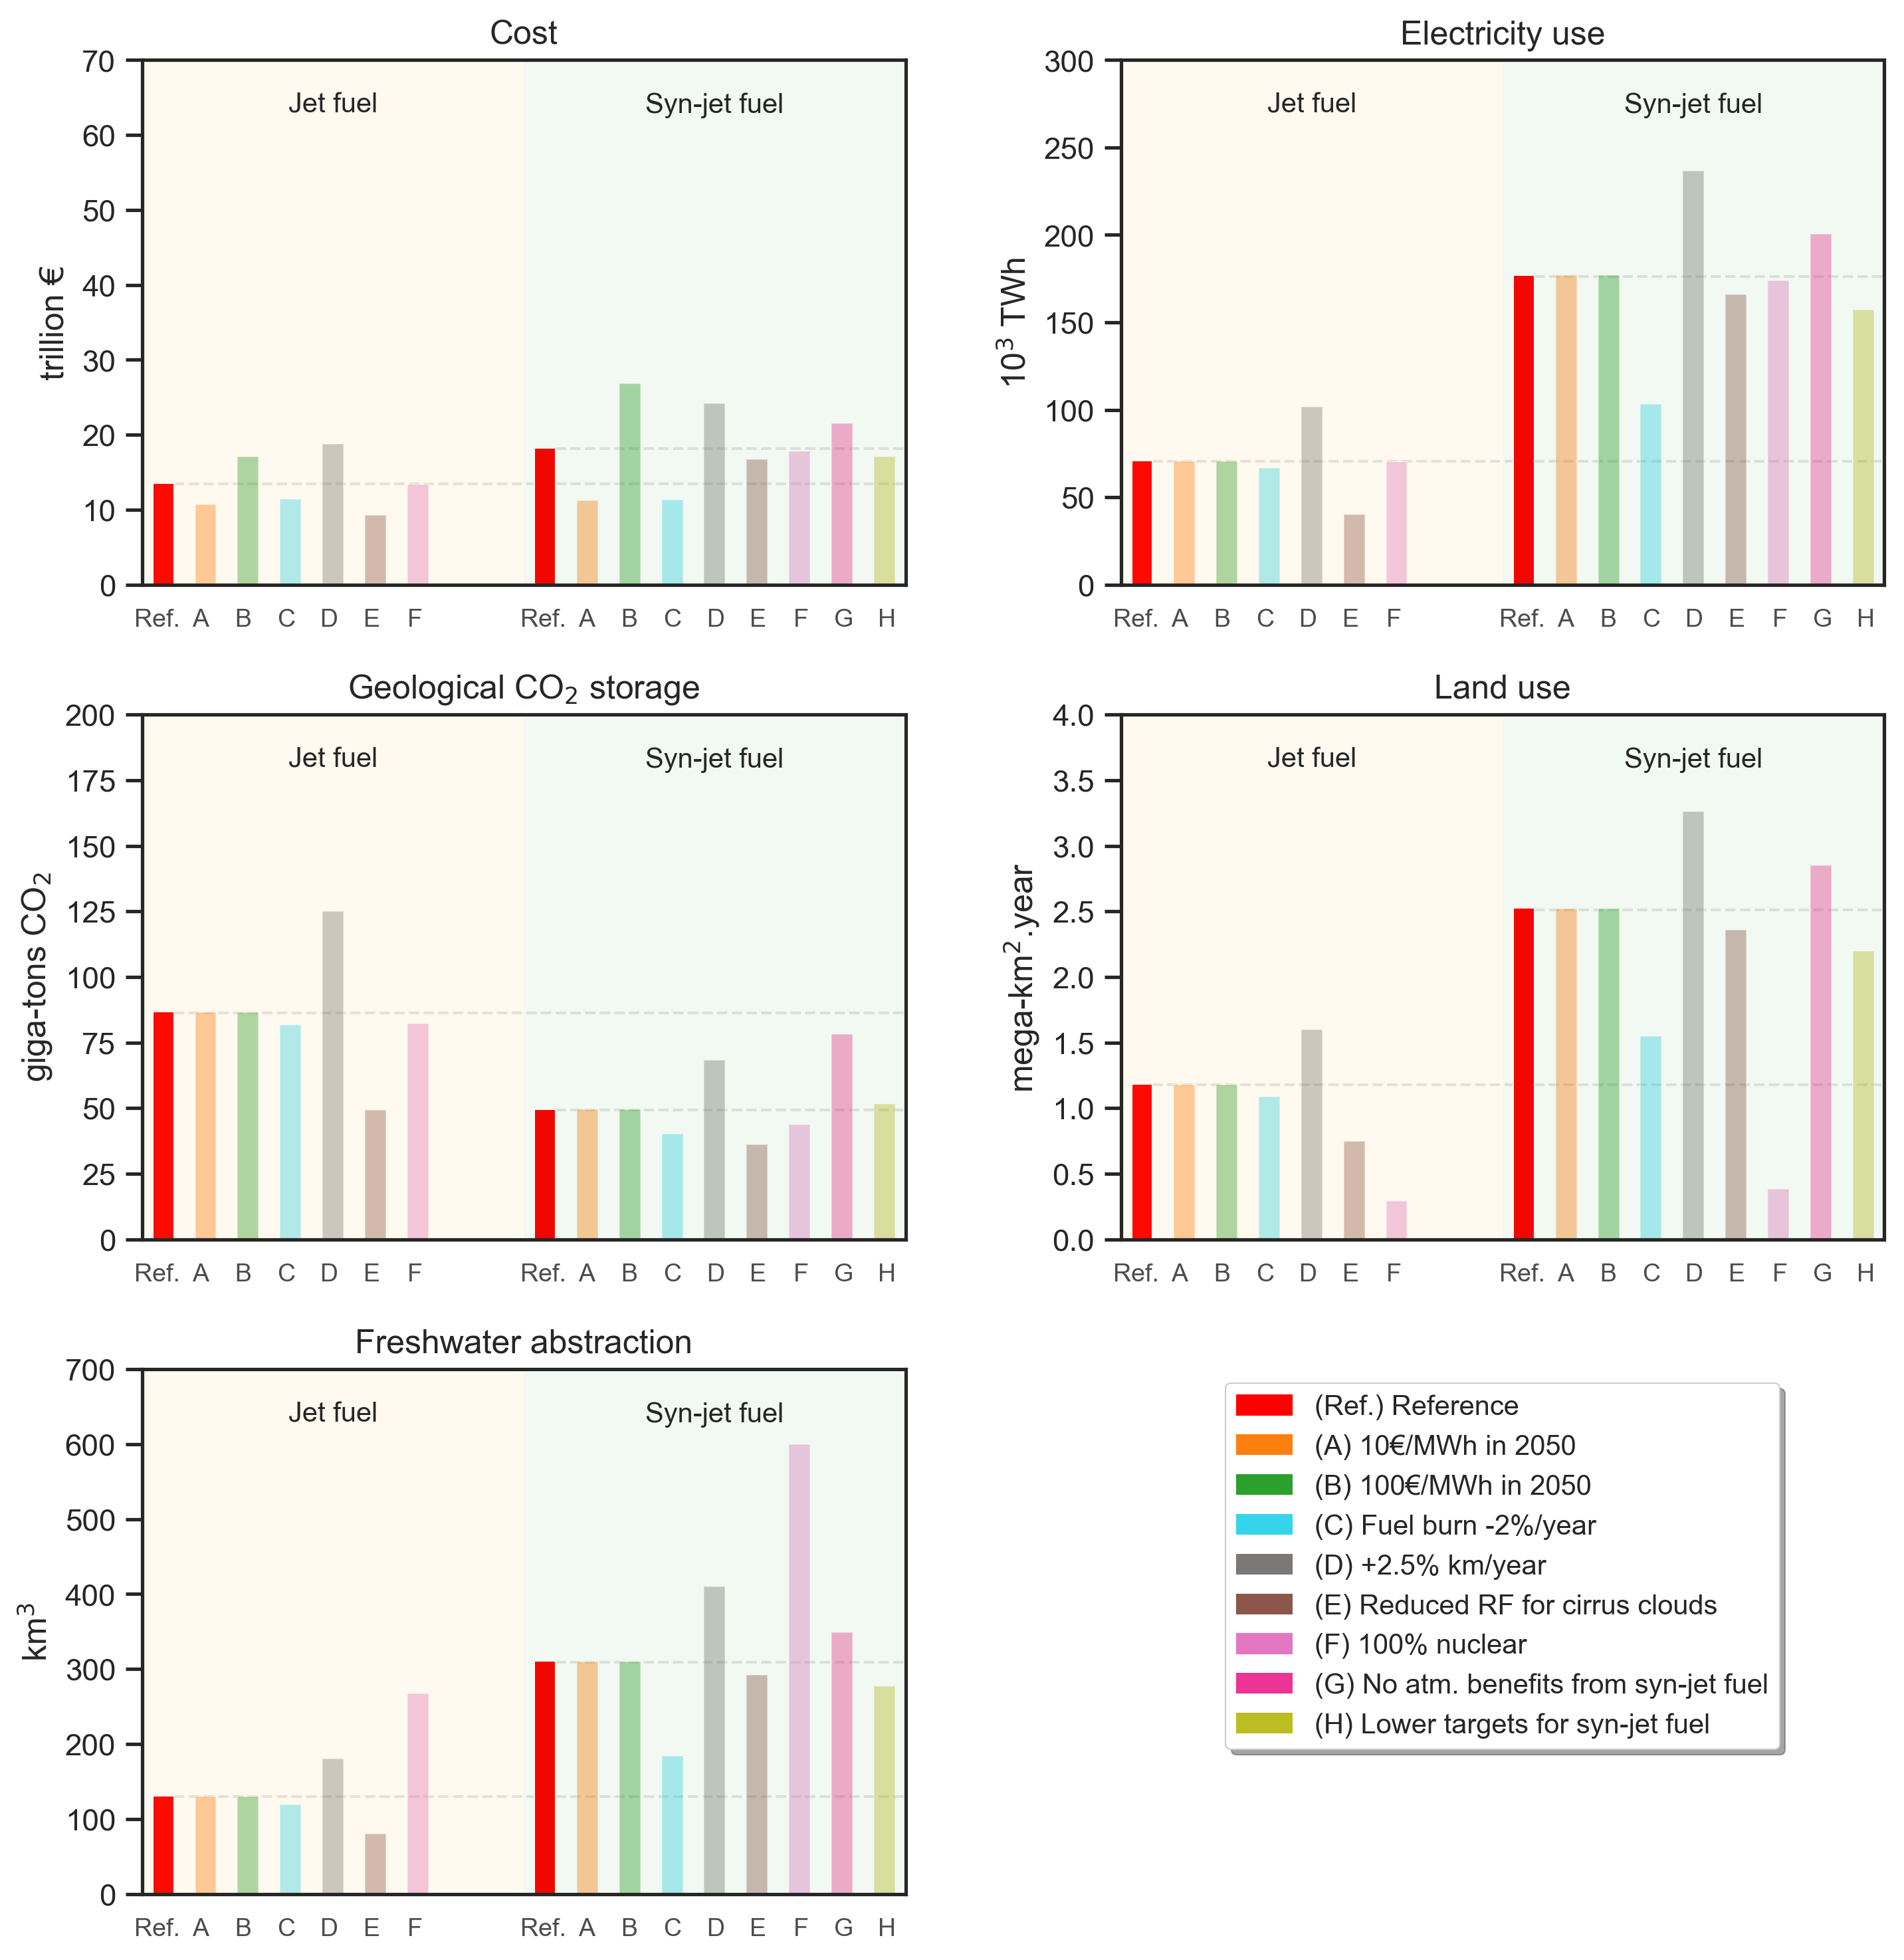

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

%matplotlib inline
sns.set_theme(style="white")
sns.set_context(rc = {'patch.linewidth': 0.5})

plt.rcParams["figure.figsize"] = (10, 10)
fig, axs = plt.subplots(3, 2, sharex=False, sharey=False)

row = 0
col = 0

colors = ['red', u'#ff7f0e', u'#2ca02c', u'#34d5eb', u'#7a7977', u'#8c564b', u'#e377c2', u'#eb3493', u'#bcbd22']

for c, category in enumerate(df.columns):
    if c > 0:
        if c % 2 == 0:
            row += 1
            col = 0
        else:
            col += 1
    
    
    data = df.loc[:, category]
    
    
    
    if category=="Cost":
        axs[row, col].set_ylim(0, 70)
        
    if category=="Electricity":
        axs[row, col].set_ylim(0, 300)
        
    if category=="CO$_2$ storage":
        axs[row, col].set_ylim(0, 200)
        
    if category=="Land use":
        axs[row, col].set_ylim(0, 4.0e0)
        
    if category=="Freshwater\nabstraction":
        axs[row, col].set_ylim(0, 700)
    
    df.loc[:, category].plot(kind="bar", ax=axs[row, col], color=colors)
    for i in range(1, 8):
        axs[row, col].get_children()[i].set_alpha(0.4)
    for i in range(10, 18):
        axs[row, col].get_children()[i].set_alpha(0.4)
        
    for x, i in enumerate(data.loc["Reference"]):
        if x == 0:
            axs[row, col].plot([0.25, 17.5], [i * 0.995, i * 0.995], lw=1, c="gray", alpha=.2, linestyle="--", zorder=-10)
        else:
            axs[row, col].plot([9.25, 17.5], [i * 0.995, i * 0.995], lw=1, c="gray", alpha=.2, linestyle="--", zorder=-10)
    
        

    axs[row, col].axvspan(-.5, 8.5, color='orange', alpha=0.06, lw=0)
    axs[row, col].axvspan(8.5, 17.5, color='green', alpha=0.05, lw=0)
    
    axs[row, col].annotate("Jet fuel", [0.25, .9], annotation_clip=False, fontsize=10, ha='center', xycoords="axes fraction")
    axs[row, col].annotate("Syn-jet fuel", [.75, .9], annotation_clip=False, fontsize=10, ha='center', xycoords="axes fraction")

axs[0, 0].set_xticklabels([])
axs[0, 1].set_xticklabels([])
axs[1, 0].set_xticklabels([])
axs[2, 0].set_xticklabels([])
axs[1, 1].set_xticklabels([])
axs[0, 0].set_xlabel("")
axs[0, 1].set_xlabel("")
axs[1, 0].set_xlabel("")
axs[1, 1].set_xlabel("")
axs[2, 0].set_xlabel("")

axs[0, 0].set_ylabel("trillion €")
axs[0, 1].set_ylabel("10$^3$ TWh")
axs[1, 0].set_ylabel("giga-tons CO$_2$")
axs[1, 1].set_ylabel("mega-km$^2$.year")
axs[2, 0].set_ylabel("km$^3$")

axs[0, 0].set_title("Cost")
axs[0, 1].set_title("Electricity use")
axs[1, 0].set_title("Geological CO$_2$ storage")
axs[1, 1].set_title("Land use")
axs[2, 0].set_title("Freshwater abstraction")



list_patches = []
for x, i in enumerate([
    "(Ref.) Reference", 
    "(A) 10€/MWh in 2050", # 1
    "(B) 100€/MWh in 2050", # 2
    "(C) Fuel burn -2%/year", # 3
    "(D) +2.5% km/year", # 6
    "(E) Reduced RF for cirrus clouds", # 8
    "(F) 100% nuclear", # 5
    "(G) No atm. benefits from syn-jet fuel", # 4
    "(H) Lower targets for syn-jet fuel", # 7
]):
    list_patches.append(
        mpatches.Patch(color=colors[x], label=i)
    )


axs[2,1].legend(handles = list_patches, loc="upper center", ncol=1, fancybox=True, shadow=True, fontsize=10)

axs[2,1].axis('off')

###########################################


for ax in [[0, 0], [0, 1], [1,0], [1, 1], [2, 0], ]:
    x_coord = -10
    for x, txt in enumerate(["Ref.", "A", "B", "C", "D", "E", "F", "G", "H"] * 2):
        x_coord += 15.5
        
        if x in [7, 8]:
            continue
            
        axs[ax[0], ax[1]].annotate(txt, [x_coord, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')

############################################

axs[0, 0].yaxis.set_ticks_position('left')
axs[0, 1].yaxis.set_ticks_position('left')
axs[1, 0].yaxis.set_ticks_position('left')
axs[1, 1].yaxis.set_ticks_position('left')
axs[2, 0].yaxis.set_ticks_position('left')

plt.tight_layout()
plt.gcf().set_dpi(300)

plt.savefig("sensitivity_results.png", dpi=300)